### A common job in Data Science is simply to analyze the data and answer common questions

The datasets/directory contains fifty CSV files (one per week) of timestamped sales data. Each row in a file has two columns:  

sale_time - The timestamp on which the sale was made e.g. 2012-10-01 01:42:22  
purchaser_gender - The gender of the person who purchased (male or female)

### Plot daily sales for all 50 weeks.

In [3]:
# import libraries 
import pandas as pd
import matplotlib.pyplot as plt
# will see purpose next
import glob

In [4]:
# get all filenames under the data directory
# python.plainenglish.io/glob-and-pandas-working-in-unison-304242627e78
l = [pd.read_csv(filename) for filename in glob.glob("./data/*.csv")]

# check the list size to understand how many files will be read
# should be equal to 50
print(len(l))

50


In [5]:
# create the dataset using all files under the data directory
df = pd.concat(l, axis=0)
df.head()

,sale_time,purchaser_gender
0,2013-01-07 02:14:07,female
1,2013-01-07 02:57:53,male
2,2013-01-07 02:59:49,female
3,2013-01-07 03:02:53,male
4,2013-01-07 03:27:36,female


In [7]:
# convert the column datatype to DateTime.
sale_day = pd.to_datetime(df['sale_time'])
sale_day.head()

0   2013-01-07 02:14:07
1   2013-01-07 02:57:53
2   2013-01-07 02:59:49
3   2013-01-07 03:02:53
4   2013-01-07 03:27:36
Name: sale_time, dtype: datetime64[ns]

In [8]:
# get the day by flooring the timestamp to the closest day
closest_day = sale_day.dt.floor('d')
# chain groupby() with size() and name the column using reset_index(), which also resets our index (duhhh)
daily_sales_df = sale_day.groupby(closest_day).size().reset_index(name='sales_amount')
# quick rename since we took closest day
daily_sales_df.rename(columns={'sale_time':'sale_day'},inplace=True)
# boom
daily_sales_df.head()

,sale_day,sales_amount
0,2012-10-01,514
1,2012-10-02,482
2,2012-10-03,499
3,2012-10-04,546
4,2012-10-05,476


<AxesSubplot: title={'center': 'Daily sales over 50 weeks'}, xlabel='sale_day'>

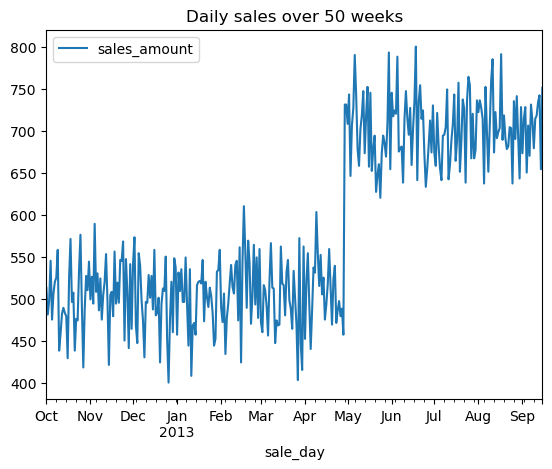

In [9]:
# practice using instead of matplotlib
# time series data is best visualized 
daily_sales_df.plot(x='sale_day', y='sales_amount', kind='line', title = "Daily sales over 50 weeks")

### It looks like there has been a sudden change in daily sales. At what date did it occur?

In [13]:
# use diff() to calculate numerical derivative and store vals in a new column
daily_sales_df["diff_from_yesterday"] = daily_sales_df["sales_amount"].diff()
# find idx of max value of our new column and index into the df using it, just return the day
biggest_change = daily_sales_df.loc[daily_sales_df["diff_from_yesterday"].idxmax()]
# spit it out
biggest_change.sale_day

Timestamp('2013-04-29 00:00:00')

### Is the change in daily sales at that date statistically significant? If so, what is the p-value?

In [14]:
# scipy.stats include a function to do t-test and obtain p-value
from scipy import stats

# first drop all nan values (if any) for the test 
daily_sales_df.dropna(inplace=True)

# then compare the max change with all sales_amount column to understand its statistical importance
stats.ttest_1samp(daily_sales_df['sales_amount'], biggest_change["sales_amount"])

Ttest_1sampResult(statistic=-26.273266340051002, pvalue=1.3019593251472396e-84)

The p-value from the t-test is 1.3019593251472396e-84, which is lower than 0.05 (threshold as 0.05 is common practice). It leads to decide this particular date is important for us.

### Does the data suggest that the change in daily sales is due to a shift in the proportion of male-vs-female customers?

In [15]:
# make change permanent in our original df
df['sale_day'] = pd.to_datetime(df['sale_time']).dt.floor('d')
# chain groupby() with size() since we've removed nulls (size() still counts nulls unlike count())
gender_portions_df = df.groupby(['sale_day', 'purchaser_gender']).size().reset_index(name='sales_amount')
gender_portions_df.head()

,sale_day,purchaser_gender,sales_amount
0,2012-10-01,female,413
1,2012-10-01,male,101
2,2012-10-02,female,379
3,2012-10-02,male,103
4,2012-10-03,female,386


In [16]:
# create a new df plotting female and male sales in individual columns
new_df = pd.DataFrame(gender_portions_df['sale_day'].unique(),columns=['sale_day'])
new_df['female_sales_amount'] = pd.Series(gender_portions_df[gender_portions_df.purchaser_gender == 'female']['sales_amount']).reset_index(drop=True)
new_df['male_sales_amount'] = pd.Series(gender_portions_df[gender_portions_df.purchaser_gender == 'male']['sales_amount']).reset_index(drop=True)


<AxesSubplot: >

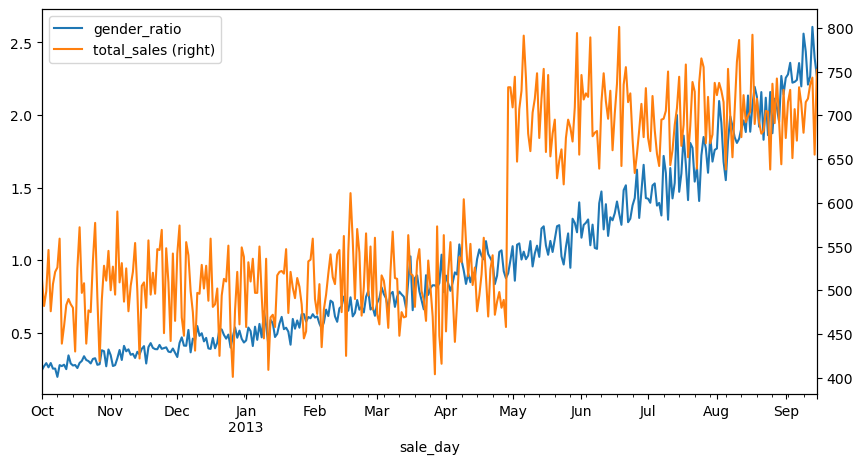

In [109]:
# calculate gender ratio of sales
new_df['gender_ratio'] = new_df['male_sales_amount']/new_df['female_sales_amount']
# calculate total
new_df["total_sales"] = new_df['male_sales_amount'] + new_df['female_sales_amount']

# observe if these calculated cols are correlated?
fig, ax = plt.subplots(figsize=(20,10)) 
new_df.plot(x="sale_day", y=["gender_ratio"], ax = ax, kind="line", figsize=(10, 5))
new_df.plot(x="sale_day", y=["total_sales"], ax = ax, kind="line", secondary_y = True)

The increasing trend of the male ratio in the sales amount does not explain the sudden change. The reason should be something different.  
For example, it might be caused by starting a new marketing campaign or adding a new feature to the website.

### Assume a given day is divided into four dayparts: night (12:00AM - 6:00AM), morning (6:00AM to 12:00PM), afternoon (12:00PM to 6:00PM) and evening (6:00PM - 12:00AM). What is the percentage of sales in each daypart over all 50 weeks?

In [20]:
# extract sale hour to divide sales to the part of days
df['sale_hour']  = pd.to_datetime(df['sale_time']).dt.ceil('h').dt.hour

In [19]:
# define a function to apply sale hour column to decide a part of day based on the mentioned logic
# further definition would be needed for sections that share an hour (6,12,18,24)
def assign_day_part(sale_hour):
    """Assign labels based on sale hour."""
    if sale_hour > 6 and sale_hour < 12:
        return 'morning'
    if sale_hour > 12 and sale_hour < 18:
        return 'afternoon'
    if sale_hour > 18 and sale_hour < 24:
        return 'evening'
    if sale_hour > -1 and sale_hour < 6:
        return 'night'

In [21]:
# apply the defined function and create day_part column
df['day_part'] = df['sale_hour'].apply(assign_day_part)
# note that this will return "None" vals given the definition containing overlap

In [23]:
# perform groupby() and count() again
day_part_sales_df = df.groupby(df.day_part).size().reset_index(name='count')
# calculate percentage dividing by .count() which ignores nulls
day_part_sales_df["percentage"] = day_part_sales_df["count"] / df['day_part'].count()
day_part_sales_df

,day_part,count,percentage
0,afternoon,68119,0.394595
1,evening,41111,0.238145
2,morning,49833,0.288669
3,night,13567,0.078590


In conclusion, we can say the customers of this company do more shopping in the afternoon and much less shopping at nights.

### Feel free to check out other notebooks in the repo!